# Setting Up

In [3]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.linalg import expm

# Notes

* Defaut DNA bases coding: T,C,A,G -> 0,1,2,3

# Functions

### generate_ancestor(n, pi=None)

In [4]:
def generate_ancestor(n, pi=None):
    """
    Generate an ancestor DNA sequence of length n with customizable probability distribution.

    Input: 
        n (integer): The desired length of the ancestor DNA sequence.
        pi (list, optional): List of probabilities for each nucleotide. If None, a random distribution is used.

    Output: 
        list: The randomly generated DNA sequence of length n in list format.
    """
    nucleotides = ['0', '1', '2', '3']  # T, C, A, G

    if pi is None:
        # If no probability distribution is provided, use a random distribution, equal probabilities of 0.25
        return list(random.choices(nucleotides, k=n))
    else:
        # If a custom probability distribution is provided, use it
        if len(pi) != 4:
            raise ValueError("Probability distribution must contain exactly 4 values.")
        
        # Check if the probabilities sum to 1
        if abs(sum(pi) - 1) > 1e-10:
            raise ValueError("Probabilities must sum to 1.")
        
        return list(random.choices(nucleotides, weights=pi, k=n))


### generate_rate_matrix()

In [5]:
def generate_rate_matrix():
    """
    Generate a single 4 by 4 rate matrix.

    Input: 
        None

    Output: 
        rate_matrix (array): A single rate matrix.

    Example output: 
    [[-0.8, 0.1, 0.4, 0.3],
    [0.3, -0.7, 0.2, 0.2],
    [0.1, 0.2, -0.6, 0.3],
    [0.1, 0.2, 0.4, -0.7]]
    """
    matrix = np.zeros((4, 4))
    for i in range(4):
        row_sum = 0 # sum of non-diagonal elements of current row
        for j in range(4):
            if i != j: # fill up non-diagonal elements of current row
                element = np.random.uniform(0.1, 1.0)  # Non-diagonal elements are between 0.01 and 1.0
                row_sum += element
                matrix[i, j] = element
        matrix[i,i] = -row_sum # Ensure every row adds up to 0 

    rate_matrix = matrix.tolist()
    return rate_matrix

### generate_rate_matrices(markov_order)

In [6]:
def generate_rate_matrices(markov_order):
    """
    Input:
        markov_order (int): The Markov order.

    Output: 
        rate_matrices (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.

    Example output: 
    generate_rate_matrices(1):
        {('0','0') :[[-0.8, 0.1, 0.4, 0.3],
                    [0.3, -0.7, 0.2, 0.2],
                    [0.1, 0.2, -0.6, 0.3],
                    [0.1, 0.2, 0.4, -0.7]],
        ('0','1') : [[...]...], ...}
    """
    rate_matrices = {}

    if markov_order == 0:
        rate_matrix = generate_rate_matrix()
        rate_matrices['0'] = rate_matrix # For standardizing so that output is always a dictionary of matrices.
        return rate_matrices
    
    else:
        nucleotides = ['0', '1', '2', '3']
        one_side_neighbours = [''.join(p) for p in itertools.product(nucleotides, repeat=markov_order)]
        permutations = list(itertools.product(one_side_neighbours, repeat=2))

        for perm in permutations:
            rate_matrix = generate_rate_matrix()
            rate_matrices[perm] = rate_matrix

        return rate_matrices

# # Example usage
# rate_matrices_dict = generate_rate_matrices(2)
# for key, value in rate_matrices_dict.items():
#     print(f"{key}: {value}")
# len(rate_matrices_dict)

### transition_matrix(Q, t)

In [7]:
def transition_matrix(Q, t):
    """
    Calculate the transition matrix P from rate matrix Q for a given time t.

    Input:
        Q: Rate matrix (2D array)
        t: Time passed (float)

    Output:
        P: Transition matrix (2D array)
    """
    Qt = np.dot(Q, t)
    P = expm(Qt)
    return P

# # Example usage:
# rate_matrices_dict = generate_rate_matrices(0)
# rate_mat_Q = rate_matrices_dict['0']
# trans_mat_P = transition_matrix(rate_mat_Q, max_time)
# print(trans_mat_P)

### get_context(seq_index, DNA_seq, markov_order, anchor_base = '0')

In [8]:
def get_context(seq_index, DNA_seq, markov_order, anchor_base = '0'):
    """
    Given the index of a base in the given DNA sequence list and order, obtain the context i.e. left and right neighbours in a tuple.

    Input: 
        seq_index (int): The index of a base in the given DNA sequence list.
        DNA_seq (list): The DNA sequence as a list.
        markov_order (int): The Markov order.
        anchor_base (string): The anchoring base beyond the DNA sequence to address incomplete nucleotide contexts at the left and right ends of the sequence.

    Output:
        context (tuple): The left and right neighbours of the base at the given seq_index.

    Example output: 
    get_context(1, ['3', '2', '3', '1', '2'], 2) = ('03', '31')
    """

    DNA_seq = ''.join(DNA_seq) # convert list DNA_seq to string 
    
    if markov_order == 0:
        return '0' # needed to access single independent matrix in rate_matrices_dict
    
    elif markov_order > 0:

        if ((seq_index < markov_order) & (len(DNA_seq) - (seq_index+1) < markov_order)): # handles incomplete left and right neighbours
            left_base = ''.join([(anchor_base * (markov_order-seq_index)), DNA_seq[:seq_index]])
            right_base =''.join([DNA_seq[seq_index+1:], (anchor_base * (markov_order - (len(DNA_seq)-seq_index-1)))])
            context = (left_base, right_base)

        elif seq_index < markov_order: # handles incomplete left neighbour
            left_base = ''.join([(anchor_base * (markov_order-seq_index)), DNA_seq[:seq_index]])
            right_base = DNA_seq[seq_index+1:seq_index+1+markov_order]
            context = (left_base, right_base)

        elif (len(DNA_seq) - (seq_index+1) < markov_order): # handles incomplete right neighbour
            left_base = DNA_seq[seq_index-markov_order:seq_index]
            right_base = ''.join([DNA_seq[seq_index+1:], (anchor_base * (markov_order - (len(DNA_seq)-seq_index-1)))])
            context = (left_base, right_base)

        else:
            left_base = DNA_seq[seq_index-markov_order:seq_index]
            right_base = DNA_seq[seq_index+1:seq_index+1+markov_order]
            context = (left_base, right_base)
        return context

# # Example usage:
# ancestor_sequence = generate_ancestor(5)
# print(ancestor_sequence)
# print(get_context(1,ancestor_sequence,0))
# print(get_context(1,ancestor_sequence,2))
# print(get_context(1,ancestor_sequence,4))

### initialize_waiting_times(DNA_seq, Q_dict, markov_order)

In [9]:
def initialize_waiting_times(DNA_seq, Q_dict, markov_order):
    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        Q_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): The Markov order.

    Output: 
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
    """
    waiting_times = np.full((len(DNA_seq),4), float('inf'))
    min_time = float('inf')
    min_position = None

    for seq_index in range(len(DNA_seq)):
        curr_base = int(DNA_seq[seq_index])

        curr_context = get_context(seq_index, DNA_seq, markov_order)

        for next_base in range(4):
            if next_base != curr_base:
                rate = 1/(Q_dict[curr_context][curr_base][next_base])
                time = np.random.exponential(rate)
                waiting_times[seq_index, next_base] = time
                if time < min_time:
                    min_time = time
                    min_position = (seq_index, next_base)

    return waiting_times, min_position, min_time

# # Example usage:
# ancestor_seq = generate_ancestor(5)
# print(f"Ancestor sequence is {ancestor_seq}")
# Q_dict = generate_rate_matrices(1)
# waiting_times, min_position, min_time = initialize_waiting_times(ancestor_seq, Q_dict, 1)
# print(waiting_times)

### get_neighbour_indices(DNA_seq, seq_index, markov_order)

In [10]:
def get_neighbour_indices(DNA_seq, seq_index, markov_order):

    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        seq_index (int): The index of a base in the given DNA sequence list.
        markov_order (int): The Markov order.

    Output:
        neighbours (array): An array of indices of the left and right neighbours of the given base at the given
            index in the DNA sequence, including the given index.
    """
    neighbours = []
    sequence_length = len(DNA_seq)

    if ((seq_index < 0) | (seq_index >= sequence_length)):
        print("Error: Index out of bounds")
    
    else:

        for index in range(max(0, seq_index - markov_order), min(sequence_length, seq_index + markov_order + 1)):
            neighbours.append(index)

        return neighbours

# # Example usage:
# sequence = '123012301'
# index = 6
# order = 2
# result = get_neighbour_indices(sequence, index, order)
# print(result)


### update_waiting_times(DNA_seq, waiting_times, Q_dict, min_position, min_time, markov_order)

In [11]:
def update_waiting_times(DNA_seq, Q_dict, waiting_times, min_position, min_time, markov_order):
    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        Q_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
        markov_order (int): The Markov order.

    Output:
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
    """

    seq_index = min_position[0] # obtain the index of the current base that is about to be substituted in the sequence

    new_base = min_position[1] # obtain the new base that is going to substitute the current base
    
    DNA_seq[seq_index] = f"{new_base}" # Substitue with new base in DNA sequence 

    # Regenerate all waiting times
    waiting_times, min_position, min_time = initialize_waiting_times(DNA_seq, Q_dict, markov_order)

    return waiting_times, min_position, min_time

# # Example usage:
# ancestor_seq = generate_ancestor(3)
# print(f"Ancestor sequence is {ancestor_seq}")
# Q_dict = generate_rate_matrices(1)
# waiting_times, min_position, min_time = initialize_waiting_times(ancestor_seq, Q_dict, 1)
# update_waiting_times(ancestor_seq, Q_dict, waiting_times, min_position, min_time, 1)

### simulate_seq(ancestor_seq, max_time, rate_matrices_dict, markov_order)

In [12]:
def simulate_seq(ancestor_seq, max_time, rate_matrices_dict, markov_order):
    """
    Input:
        ancestor_seq (list): The initial non-substituted generated DNA sequence of length n.
        max_time (float): The maximum time allowed for substitution(s) to take place in the simulation.
        rate_matrices (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): The Markov order.

    Output:
        tuple: A tuple containing the final DNA sequence at the end of the simulation as well as an array
        containing the history of substituted DNA sequences throughout the simulation.
        
    """
    history = [ancestor_seq,]

    time_passed = 0

    DNA_seq = ancestor_seq.copy()
    Q_dict = rate_matrices_dict
    waiting_times, min_position, min_time = initialize_waiting_times(DNA_seq, Q_dict, markov_order)

    while time_passed <= max_time:
        seq_index = min_position[0]
        new_base = min_position[1]
        substitution_time = min_time 
        waiting_times, min_position, min_time = update_waiting_times(DNA_seq, Q_dict, waiting_times, min_position, min_time, markov_order)
        DNA_seq[seq_index] = f"{new_base}" # Substitue with new base in DNA sequence
        history.append(DNA_seq.copy())
        time_passed += substitution_time

    if len(history) <= 2: # meaning time for any substitution to occur exceeded the max_time, no substitution took place
        return (ancestor_seq, history[:-1])
    else:
        return (history[-2], history[:-1])
    
# # Example usage:
# ancestor_seq = generate_ancestor(3)
# print(f"Ancestor sequence is {ancestor_seq}")
# order = 1
# max_time = 0.2
# rate_matrices_dict = generate_rate_matrices(order)
# simulate_seq(ancestor_seq,max_time,rate_matrices_dict,order)

# Simulation Study

In [13]:
def generate_stats(theo_df, sim_df):
    """ 
    
    Input: 
        theo_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
        
    Output:
        None        
    """
    # Calculate mean, standard deviation, and standard error for each column
    mean_sim = sim_df.mean()
    std_sim = sim_df.std()
    se_sim = std_sim / np.sqrt(len(sim_df))

    # Compare with theoretical values
    for col in sim_df.columns:
        print(f"Mean Simulated Proportion for {col}: {mean_sim[col]}")
        print(f"Theoretical Probability for {col}: {theo_df[col].iloc[0]}")
        print(f"Standard Error for {col}: {se_sim[col]}")
        print(f"Z-score for {col}: {(mean_sim[col] - theo_df[col].iloc[0])/se_sim[col]}")
        print()

## Simulation 1: Start with sequence of all A, independent substitution.

In [15]:
def A_simulation(repeat, ancestor_seq, max_time, rate_matrices_dict, markov_order):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        ancestor_seq (list): Starting DNA sequence of each repeat.
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
    """

    rate_mat_Q = rate_matrices_dict['0']
    trans_mat_P = transition_matrix(rate_mat_Q, max_time)
    theo_probs = trans_mat_P[2] # Only consider with the row of probabilities where starting base is A / '2'
    theo_probs_dict = {str(i): theo_probs[i] for i in range(4)}

    simulated_props = {}

    for i in range(repeat):
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        nucleotide_counts = {'0': 0, '1': 0, '2': 0, '3': 0}
        nucleotide_counts.update(Counter(final_seq)) # Update counts based on the final sequence
        seq_length = len(final_seq) 
        sim_prop = {nucleotide: count / seq_length for nucleotide, count in nucleotide_counts.items()}
        simulated_props[i+1] = sim_prop

    # Convert dictionaries to DataFrames
    theo_probs_df = pd.DataFrame([theo_probs_dict])
    sim_props_df = pd.DataFrame.from_dict(simulated_props, orient='index')
        
    return theo_probs_df, sim_props_df

In [16]:
num_repeat = 100
pi = [0,0,1,0]
ancestor_seq = generate_ancestor(1000,pi=pi)
max_time = 0.1
order = 0 # independent
rate_matrices_dict = {'0': np.array([[-0.6, 0.1, 0.2, 0.3],
                                     [0.1, -0.65, 0.15, 0.4],
                                     [0.2, 0.1, -0.8, 0.5],
                                     [0.3, 0.2, 0.1, -0.6]])}

In [17]:
A_theo_df, A_sim_df = A_simulation(num_repeat, ancestor_seq, max_time, rate_matrices_dict, order)

In [18]:
A_theo_df

,0,1,2,3
0,0.019407,0.009869,0.923614,0.047111


In [19]:
A_sim_df

,0,1,2,3
1,0.025,0.005,0.926,0.044
2,0.027,0.008,0.912,0.053
3,0.021,0.007,0.921,0.051
4,0.023,0.008,0.929,0.040
5,0.022,0.009,0.919,0.050
...,...,...,...,...
96,0.018,0.010,0.906,0.066
97,0.023,0.007,0.923,0.047
98,0.014,0.008,0.927,0.051
99,0.016,0.007,0.936,0.041


In [20]:

def plot_histograms(theo_df, sim_df):
    nucleotides = ['0', '1', '2', '3']
    bins = 20

    # Set up a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for i, nucleotide in enumerate(nucleotides):
        row, col = divmod(i, 2)
        ax = axs[row, col]

        ax.hist(sim_df[nucleotide], bins=bins, alpha=0.5, label='Simulated', color='blue')
        ax.axvline(x=theo_df[nucleotide][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=sim_df[nucleotide].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {nucleotide} Proportions')
        ax.legend()

    # Adjust layout 
    plt.tight_layout()
    plt.show()

    return

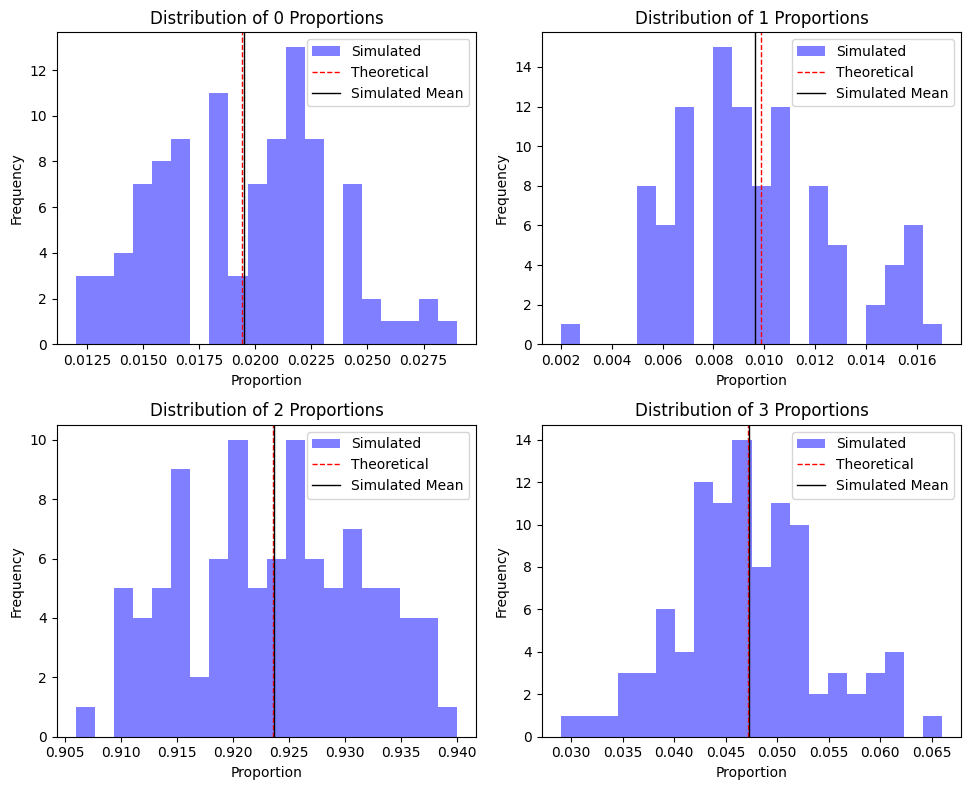

In [21]:
plot_histograms(A_theo_df, A_sim_df)

### Simulation statistics:

In [22]:
A_theo_df

,0,1,2,3
0,0.019407,0.009869,0.923614,0.047111


In [23]:
A_sim_df

,0,1,2,3
1,0.025,0.005,0.926,0.044
2,0.027,0.008,0.912,0.053
3,0.021,0.007,0.921,0.051
4,0.023,0.008,0.929,0.040
5,0.022,0.009,0.919,0.050
...,...,...,...,...
96,0.018,0.010,0.906,0.066
97,0.023,0.007,0.923,0.047
98,0.014,0.008,0.927,0.051
99,0.016,0.007,0.936,0.041


In [24]:
generate_stats(A_theo_df, A_sim_df)

Mean Simulated Proportion for 0: 0.0195
Theoretical Probability for 0: 0.019406581873457375
Standard Error for 0: 0.00038755905382537536
Z-score for 0: 0.24104230212285763

Mean Simulated Proportion for 1: 0.00964
Theoretical Probability for 1: 0.009868527666658427
Standard Error for 1: 0.0003198863434522842
Z-score for 1: -0.7144026975084531

Mean Simulated Proportion for 2: 0.9236400000000002
Theoretical Probability for 2: 0.9236135683026526
Standard Error for 2: 0.0008012011185234531
Z-score for 2: 0.03299009042364911

Mean Simulated Proportion for 3: 0.047220000000000005
Theoretical Probability for 3: 0.04711132215723161
Standard Error for 3: 0.0007023165132961668
Z-score for 3: 0.15474197275861115



In [25]:
# generate_z_score(A_theo_df, A_sim_df)

## Simulation 2: Different starting sequence, independent

In [26]:
def count_change_props(starting_seq, final_seq):
    """ 
    Input:
        starting_seq (list): Starting DNA sequence.
        final_seq (list): Final DNA sequence after one run of simulation.

    Output:
        changes_proportions (dict): A dictionary of proportions of each possible transition.
    """
    changes_counter = Counter(zip(starting_seq, final_seq))
    changes_proportions = {}

    nucleotide_counts = {'0': 0, '1': 0, '2': 0, '3': 0}
    nucleotide_counts.update(Counter(starting_seq)) # Update counts based on the starting sequence

    seq_length = len(starting_seq)

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            key = f"{from_nucleotide}_to_{to_nucleotide}"
            count = changes_counter[(from_nucleotide, to_nucleotide)]
            proportion = count / seq_length
            changes_proportions[key] = proportion

    return changes_proportions

# # Example usage:
# starting_seq = '0000000000'
# final_seq = '0123020010'
# proportions = count_change_props(starting_seq, final_seq)
# print(proportions)


In [27]:
def simulation2(repeat, n, pi, max_time, rate_matrices_dict, markov_order):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        n (int): Length of DNA sequence.
        pi (list): List of probabilities for each nucleotide. 
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
    """

    rate_mat_Q = rate_matrices_dict['0']
    trans_mat_P = transition_matrix(rate_mat_Q, max_time)
    pi_diag = np.diag(pi)
    joint_mat_J = np.dot(pi_diag, trans_mat_P) 
    theo_probs_dict = {}
    for i in range(4):
        for j in range(4):
            theo_probs_dict[f'{i}_to_{j}'] = joint_mat_J[i,j]

    simulated_props = {}

    for i in range(repeat):
        ancestor_seq = generate_ancestor(n, pi) # new ancestor every run
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        change_props = count_change_props(ancestor_seq, final_seq)
        simulated_props[i+1] = change_props

    theo_probs_df = pd.DataFrame([theo_probs_dict])
    sim_props_df = pd.DataFrame.from_dict(simulated_props, orient='index')
        
    return theo_probs_df, sim_props_df

In [28]:
num_repeat = 100
n = 1000
pi = [0.1,0.4,0.3,0.2]
max_time = 0.1
order = 0 # independent
rate_matrices_dict = {'0': np.array([[-0.6, 0.1, 0.2, 0.3],
                                     [0.1, -0.65, 0.15, 0.4],
                                     [0.2, 0.1, -0.8, 0.5],
                                     [0.3, 0.2, 0.1, -0.6]])}


mix_theo_df, mix_sim_df = simulation2(num_repeat, n, pi, max_time, rate_matrices_dict, order)


In [29]:
def plot_histograms2(theo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=theo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

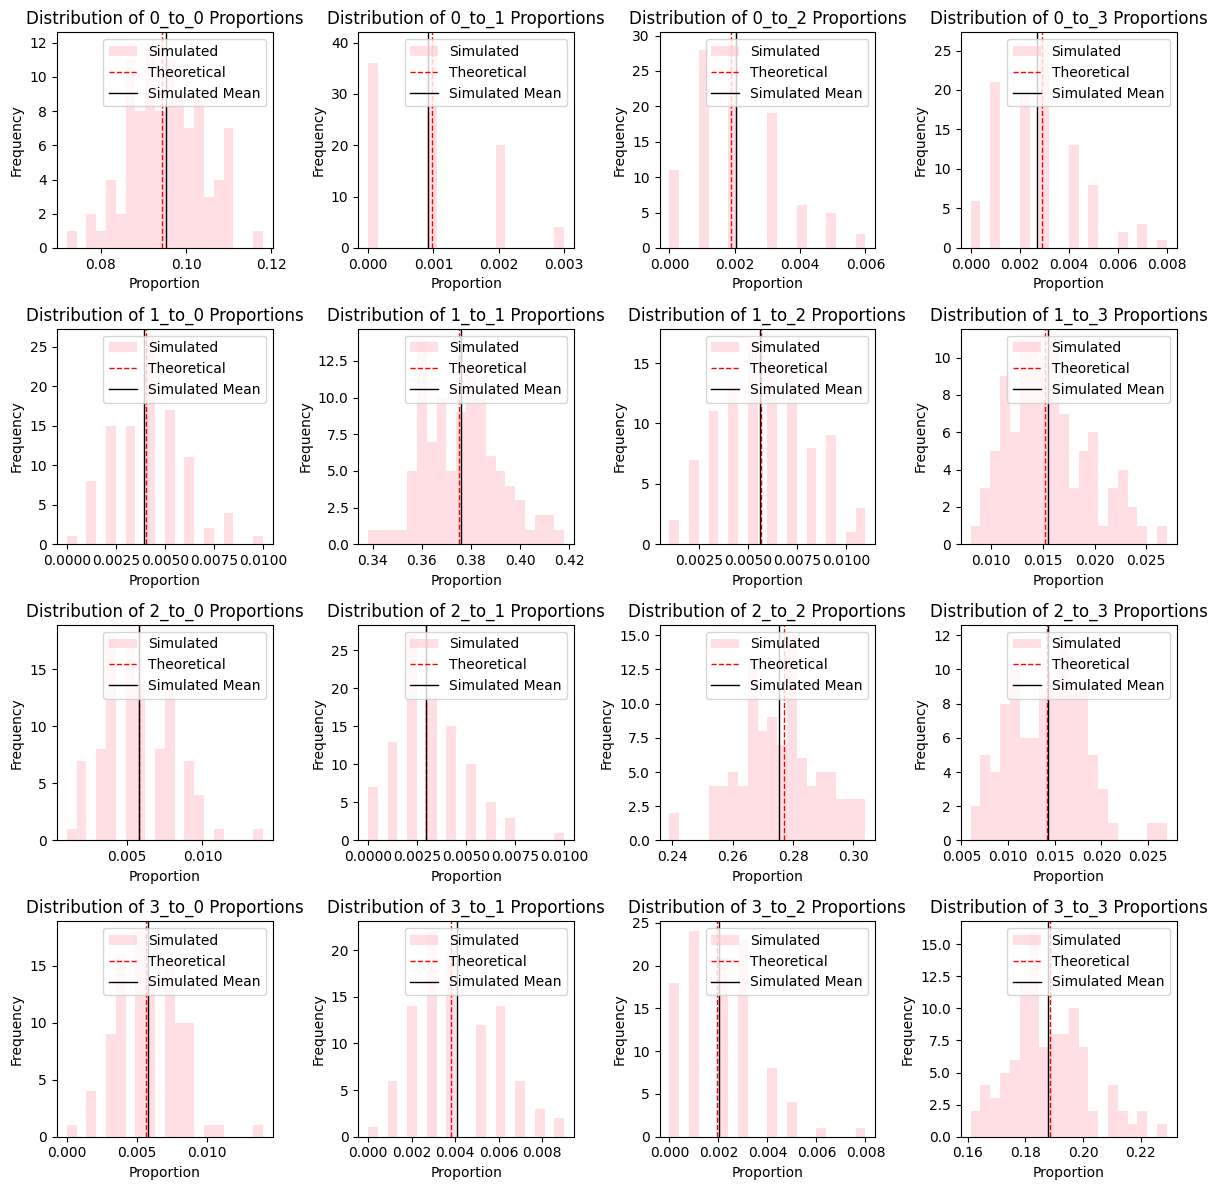

In [30]:
plot_histograms2(mix_theo_df, mix_sim_df)

### Simulation Statistics

In [31]:
mix_theo_df

,0_to_0,0_to_1,0_to_2,0_to_3,1_to_0,1_to_1,1_to_2,1_to_3,2_to_0,2_to_1,2_to_2,2_to_3,3_to_0,3_to_1,3_to_2,3_to_3
0,0.094243,0.000978,0.001887,0.002892,0.004043,0.375027,0.005696,0.015235,0.005822,0.002961,0.277084,0.014133,0.005691,0.003797,0.00195,0.188562


In [32]:
mix_sim_df

,0_to_0,0_to_1,0_to_2,0_to_3,1_to_0,1_to_1,1_to_2,1_to_3,2_to_0,2_to_1,2_to_2,2_to_3,3_to_0,3_to_1,3_to_2,3_to_3
1,0.090,0.000,0.001,0.005,0.004,0.356,0.011,0.015,0.003,0.002,0.287,0.027,0.008,0.006,0.001,0.184
2,0.094,0.001,0.002,0.003,0.003,0.383,0.005,0.016,0.009,0.000,0.274,0.011,0.004,0.008,0.002,0.185
3,0.103,0.001,0.002,0.002,0.005,0.381,0.007,0.014,0.004,0.002,0.269,0.016,0.005,0.006,0.000,0.183
4,0.102,0.001,0.001,0.002,0.002,0.387,0.005,0.021,0.005,0.005,0.239,0.011,0.003,0.003,0.001,0.212
5,0.077,0.001,0.002,0.003,0.003,0.412,0.003,0.010,0.005,0.001,0.256,0.020,0.011,0.004,0.003,0.189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.105,0.000,0.005,0.001,0.003,0.378,0.004,0.014,0.006,0.003,0.289,0.015,0.005,0.003,0.003,0.166
97,0.091,0.002,0.002,0.003,0.002,0.409,0.002,0.015,0.007,0.002,0.277,0.014,0.006,0.004,0.003,0.161
98,0.092,0.000,0.005,0.001,0.005,0.372,0.008,0.025,0.008,0.001,0.279,0.008,0.008,0.006,0.003,0.179
99,0.105,0.000,0.001,0.004,0.002,0.358,0.006,0.011,0.008,0.003,0.282,0.006,0.009,0.003,0.001,0.201


In [33]:
generate_stats(mix_theo_df, mix_sim_df)

Mean Simulated Proportion for 0_to_0: 0.09520999999999999
Theoretical Probability for 0_to_0: 0.09424318409273408
Standard Error for 0_to_0: 0.0008544943569507091
Z-score for 0_to_0: 1.1314479720100494

Mean Simulated Proportion for 0_to_1: 0.0009200000000000001
Theoretical Probability for 0_to_1: 0.0009776981649529054
Standard Error for 0_to_1: 8.490041700769678e-05
Z-score for 0_to_1: -0.6795981337485607

Mean Simulated Proportion for 0_to_2: 0.00204
Theoretical Probability for 0_to_2: 0.0018867087754154772
Standard Error for 0_to_2: 0.00013920408678547402
Z-score for 0_to_2: 1.101197731505961

Mean Simulated Proportion for 0_to_3: 0.00272
Theoretical Probability for 0_to_3: 0.002892408966897552
Standard Error for 0_to_3: 0.00017001485377769352
Z-score for 0_to_3: -1.014081787953591

Mean Simulated Proportion for 1_to_0: 0.00394
Theoretical Probability for 1_to_0: 0.004042794836315291
Standard Error for 1_to_0: 0.00018576622650280354
Z-score for 1_to_0: -0.5533558938591013

Mean Simu

## Simple context dependent, CpG effect

In [35]:
def CpG_rate_matrices(rate_matrix, markov_order = 1):
    """
    Input:
        rate_matrix (array): A single rate matrix.

    Output: 
        rate_matrices (dict): A dictionary of rate matrices for CpG context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
    """
    rate_matrices = {}
    
    nucleotides = ['0', '1', '2', '3']
    one_side_neighbours = [''.join(p) for p in itertools.product(nucleotides, repeat=markov_order)]
    permutations = list(itertools.product(one_side_neighbours, repeat=2))
    
    modified_rate_matrix = rate_matrix.copy()
    modified_rate_matrix[1,0] *= 10 # third row, first column contains rate for C changing to T

    for perm in permutations:
        if perm[1] == '3':
            # rates multiplied by 10 if right neighbour is G ( coded '3')
            rate_matrices[perm] = modified_rate_matrix
        else:
            rate_matrices[perm] = rate_matrix

    return rate_matrices

In [36]:
rate_matrix = np.array([[-0.6, 0.1, 0.2, 0.3],
                        [0.1, -0.65, 0.15, 0.4],
                        [0.2, 0.1, -0.8, 0.5],
                        [0.3, 0.2, 0.1, -0.6]])

rate_matrices_dict = CpG_rate_matrices(rate_matrix)
rate_matrices_dict

{('0',
  '0'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '1'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '2'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '3'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 1.  , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('1',
  '0'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('1',
  '1'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0

In [37]:
def CpG_change_props(starting_seq, final_seq):
    """ 
    Input:
        starting_seq (list): Starting DNA sequence.
        final_seq (list): Final DNA sequence after one run of simulation.

    Output:
        CpG_props_dict (dict): A dictionary of proportions of each possible transition for CpG context.
        non_CpG_props_dict (dict): A dictionary of proportions of each possible transition for non_CpG context.
    """

    seq_length = len(starting_seq)

    start_context_dict = {} # Dictionary of context for all nucleotides in starting DNA sequence.
    for i in range(seq_length):
        start_context_dict[i] = get_context(i,starting_seq,markov_order=1) 

    final_context_dict = {} # Dictionary of context for all nucleotides in final DNA sequence.
    for i in range(seq_length):
        final_context_dict[i] = get_context(i,final_seq,markov_order=1) 

    # Initializing matrices to store simulated probabilities
    CpG_props = np.zeros((4,4))
    non_CpG_props = np.zeros((4,4))

    for i in range(seq_length):
        if (start_context_dict[i] == final_context_dict[i]): # Contexts that appears to remain unchanged 
            start_base = int(starting_seq[i])
            final_base = int(final_seq[i])
            if start_context_dict[i][1] == '3': # Contexts with G / '3' as right neighbour
                CpG_props[start_base, final_base] += 1
            else:
                non_CpG_props[start_base, final_base] += 1

    # Normalizing the matrices to obtain the proportions
    CpG_props /= np.sum(CpG_props)
    non_CpG_props /= np.sum(non_CpG_props)

    # Creating dictionaries to store simulated proportions to prepare for pandas dataframe
    CpG_props_dict = {}
    non_CpG_props_dict = {}
    for i in range(4):
        for j in range(4):
            CpG_props_dict[f'CpG_{i}_to_{j}'] = CpG_props[i,j]
            non_CpG_props_dict[f'non_CpG_{i}_to_{j}'] = non_CpG_props[i,j]

    return CpG_props_dict, non_CpG_props_dict

In [38]:
def CpG_simulation(repeat, n, pi, max_time, rate_matrices_dict, markov_order = 1):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        n (int): Length of DNA sequence.
        pi (list): List of probabilities for each nucleotide. 
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        CpG_theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition for CpG context.
        CpG_sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat, for CpG context.
        non_CpG_theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition for non-CpG context.
        non_CpG_sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat, for non-CpG context.
    """

    ancestor_seq = generate_ancestor(n,pi=pi)
    
    # To simplify the number rate matrices since in the 16 matrices, there are actually only 2 different types.
    # One for CpG contexts, another non_CpG
    CpG_context = ('0', '3')
    non_CpG_context = ('0', '0')
    
    CpG_Q = rate_matrices_dict[CpG_context]
    CpG_P = transition_matrix(CpG_Q, max_time)

    non_CpG_Q = rate_matrices_dict[non_CpG_context]
    non_CpG_P = transition_matrix(non_CpG_Q, max_time)
    
    pi_diag = np.diag(pi)

    CpG_J = np.dot(pi_diag, CpG_P) 
    non_CpG_J = np.dot(pi_diag, non_CpG_P)

    CpG_theo_probs_dict = {}
    non_CpG_theo_probs_dict = {}

    for i in range(4):
        for j in range(4):
            CpG_theo_probs_dict[f'CpG_{i}_to_{j}'] = CpG_J[i,j]
            non_CpG_theo_probs_dict[f'non_CpG_{i}_to_{j}'] = non_CpG_J[i,j]

    CpG_sim_props_dict = {}
    non_CpG_sim_props_dict = {}

    for i in range(repeat):
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        CpG_sim_props, non_CpG_sim_props = CpG_change_props(ancestor_seq, final_seq)
        CpG_sim_props_dict[i+1] = CpG_sim_props
        non_CpG_sim_props_dict[i+1] = non_CpG_sim_props

    CpG_theo_probs_df = pd.DataFrame([CpG_theo_probs_dict])
    non_CpG_theo_probs_df = pd.DataFrame([non_CpG_theo_probs_dict])
    CpG_sim_props_df = pd.DataFrame.from_dict(CpG_sim_props_dict, orient='index')
    non_CpG_sim_props_df = pd.DataFrame.from_dict(non_CpG_sim_props_dict, orient='index')
        
    return CpG_theo_probs_df, CpG_sim_props_df, non_CpG_theo_probs_df, non_CpG_sim_props_df

In [39]:
num_repeat = 100
n = 1000
pi = [0.1,0.4,0.3,0.2]
max_time = 0.1
order = 1 # default for CpG
rate_matrix = np.array([[-0.6, 0.1, 0.2, 0.3],
                        [0.1, -0.65, 0.15, 0.4],
                        [0.2, 0.1, -0.8, 0.5],
                        [0.3, 0.2, 0.1, -0.6]])
rate_matrices_dict = CpG_rate_matrices(rate_matrix) # 16 rate matrices, of which 12 baselines and 4 test

In [40]:
CpG_theo_df, CpG_sim_df, non_CpG_theo_df, non_CpG_sim_df = CpG_simulation(num_repeat, n, pi, max_time, rate_matrices_dict)

In [41]:
CpG_theo_df

,CpG_0_to_0,CpG_0_to_1,CpG_0_to_2,CpG_0_to_3,CpG_1_to_0,CpG_1_to_1,CpG_1_to_2,CpG_1_to_3,CpG_2_to_0,CpG_2_to_1,CpG_2_to_2,CpG_2_to_3,CpG_3_to_0,CpG_3_to_1,CpG_3_to_2,CpG_3_to_3
0,0.094287,0.000978,0.001887,0.002893,0.037881,0.3752,0.006035,0.01575,0.005953,0.002961,0.277085,0.014135,0.005861,0.003798,0.001951,0.188564


In [42]:
CpG_sim_df

,CpG_0_to_0,CpG_0_to_1,CpG_0_to_2,CpG_0_to_3,CpG_1_to_0,CpG_1_to_1,CpG_1_to_2,CpG_1_to_3,CpG_2_to_0,CpG_2_to_1,CpG_2_to_2,CpG_2_to_3,CpG_3_to_0,CpG_3_to_1,CpG_3_to_2,CpG_3_to_3
1,0.098837,0.000000,0.000000,0.000000,0.023256,0.348837,0.000000,0.005814,0.005814,0.000000,0.325581,0.011628,0.000000,0.005814,0.000000,0.174419
2,0.095238,0.000000,0.005952,0.000000,0.023810,0.333333,0.011905,0.017857,0.000000,0.017857,0.303571,0.011905,0.005952,0.011905,0.000000,0.160714
3,0.088398,0.000000,0.000000,0.000000,0.033149,0.325967,0.016575,0.005525,0.011050,0.000000,0.325967,0.000000,0.005525,0.000000,0.000000,0.187845
4,0.095506,0.005618,0.000000,0.000000,0.050562,0.348315,0.005618,0.005618,0.005618,0.000000,0.280899,0.028090,0.011236,0.000000,0.000000,0.162921
5,0.105882,0.000000,0.000000,0.000000,0.029412,0.364706,0.005882,0.000000,0.005882,0.005882,0.294118,0.011765,0.005882,0.005882,0.005882,0.158824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.089286,0.005952,0.000000,0.000000,0.029762,0.327381,0.000000,0.017857,0.005952,0.005952,0.321429,0.011905,0.005952,0.000000,0.000000,0.178571
97,0.089385,0.000000,0.005587,0.000000,0.011173,0.357542,0.011173,0.005587,0.005587,0.000000,0.324022,0.011173,0.000000,0.000000,0.000000,0.178771
98,0.094444,0.005556,0.000000,0.000000,0.022222,0.333333,0.011111,0.011111,0.011111,0.000000,0.305556,0.005556,0.005556,0.000000,0.000000,0.194444
99,0.085227,0.000000,0.000000,0.005682,0.022727,0.340909,0.000000,0.028409,0.005682,0.000000,0.289773,0.017045,0.000000,0.000000,0.000000,0.204545


In [43]:
def CpG_histograms(hypo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"CpG_{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=hypo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

In [44]:
def non_CpG_histograms(hypo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"non_CpG_{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=hypo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

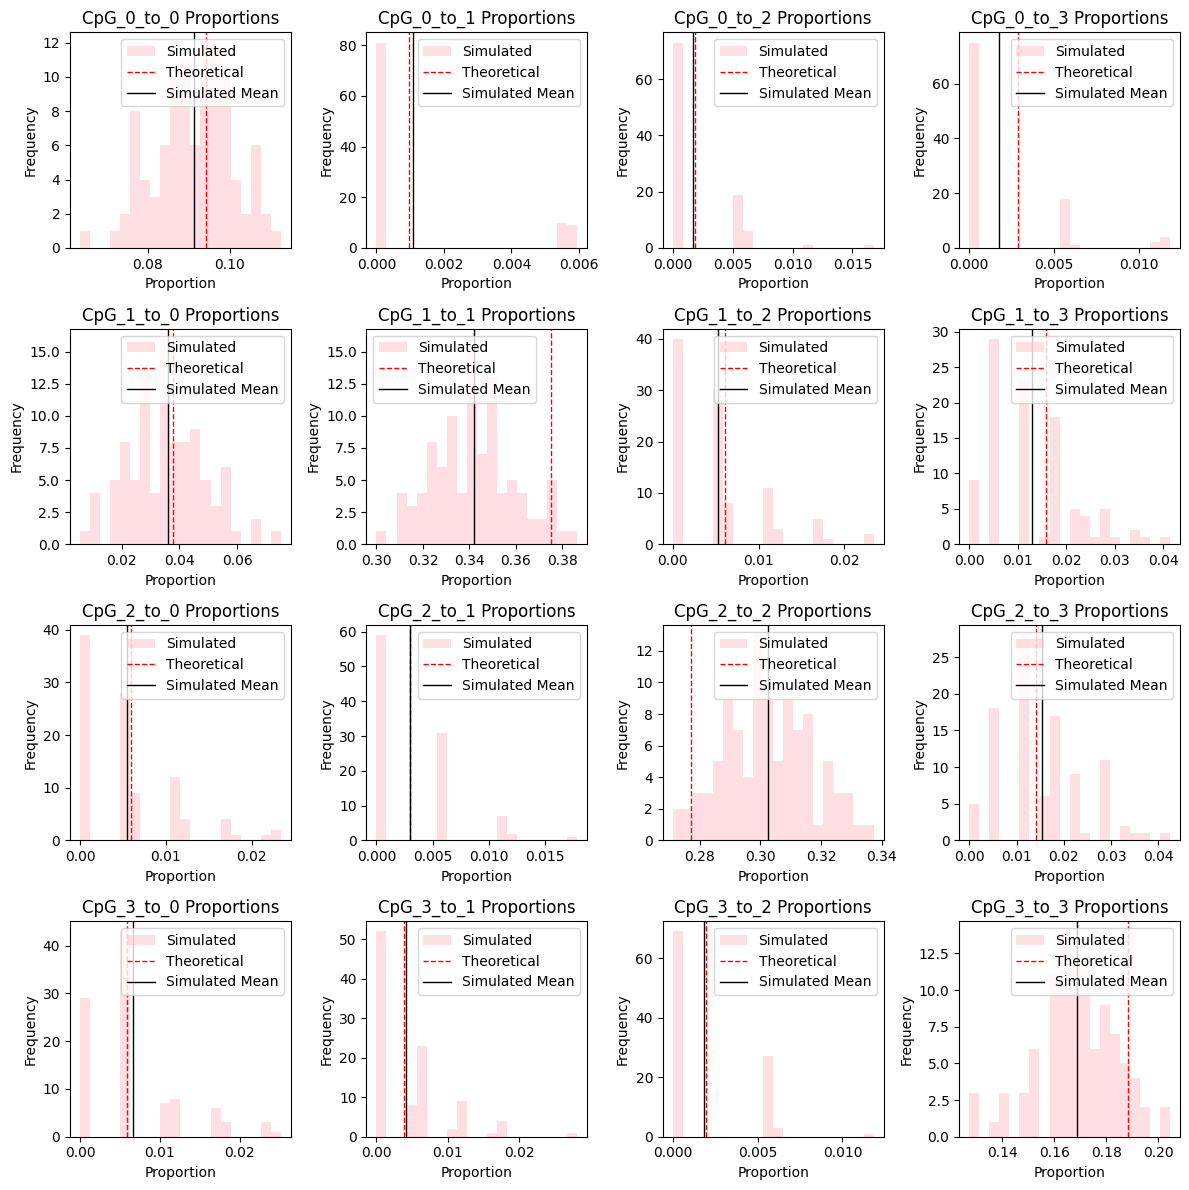

In [45]:
CpG_histograms(CpG_theo_df, CpG_sim_df)

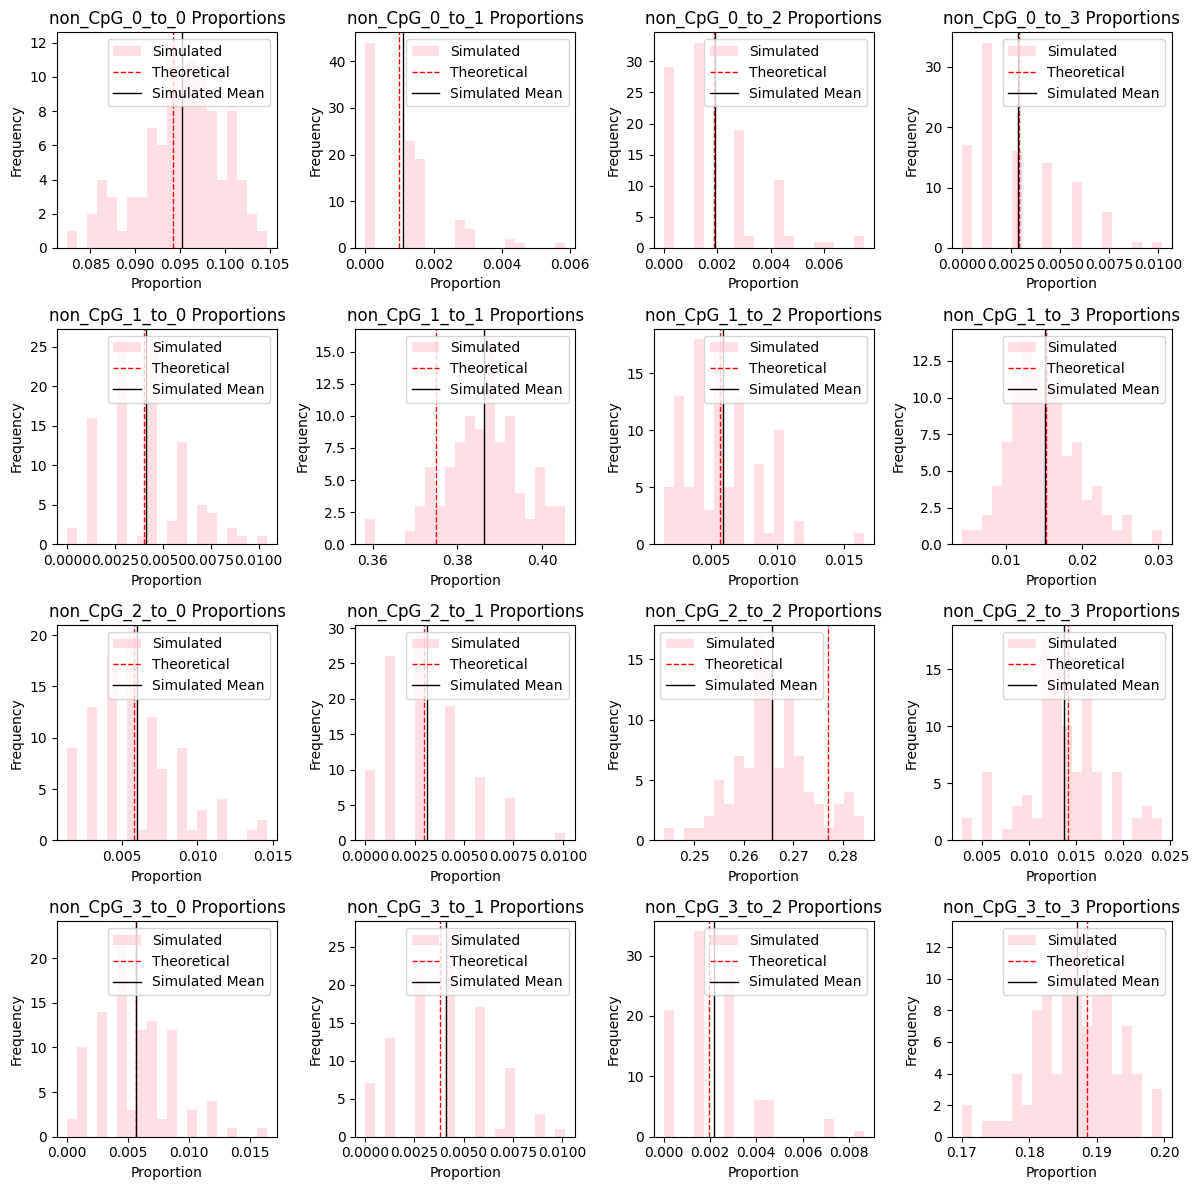

In [46]:
non_CpG_histograms(non_CpG_theo_df, non_CpG_sim_df)

### Simulation Statistics

CpG Statistics

In [47]:
generate_stats(CpG_theo_df, CpG_sim_df)

Mean Simulated Proportion for CpG_0_to_0: 0.09124467148802726
Theoretical Probability for CpG_0_to_0: 0.09428664516391436
Standard Error for CpG_0_to_0: 0.0009374842174955957
Z-score for CpG_0_to_0: -3.2448265465347856

Mean Simulated Proportion for CpG_0_to_1: 0.001080692079377283
Theoretical Probability for CpG_0_to_1: 0.0009778448293739652
Standard Error for CpG_0_to_1: 0.0002243238372909969
Z-score for CpG_0_to_1: 0.4584766881903083

Mean Simulated Proportion for CpG_0_to_2: 0.0017127635112982706
Theoretical Probability for CpG_0_to_2: 0.001886996887314347
Standard Error for CpG_0_to_2: 0.0003078824999638515
Z-score for CpG_0_to_2: -0.5659086698221987

Mean Simulated Proportion for CpG_0_to_3: 0.0017733297758461592
Theoretical Probability for CpG_0_to_3: 0.0028928458827569316
Standard Error for CpG_0_to_3: 0.00033134184055754005
Z-score for CpG_0_to_3: -3.3787344967571635

Mean Simulated Proportion for CpG_1_to_0: 0.03596076840658859
Theoretical Probability for CpG_1_to_0: 0.037880

non_CpG Statistics

In [49]:
generate_stats(non_CpG_theo_df, non_CpG_sim_df)

Mean Simulated Proportion for non_CpG_0_to_0: 0.095217772189543
Theoretical Probability for non_CpG_0_to_0: 0.09424318409273408
Standard Error for non_CpG_0_to_0: 0.00046051275172926277
Z-score for non_CpG_0_to_0: 2.1163107713071203

Mean Simulated Proportion for non_CpG_0_to_1: 0.0010965878047595298
Theoretical Probability for non_CpG_0_to_1: 0.0009776981649529054
Standard Error for non_CpG_0_to_1: 0.00012214339586827174
Z-score for non_CpG_0_to_1: 0.9733611789772374

Mean Simulated Proportion for non_CpG_0_to_2: 0.0019350069853716274
Theoretical Probability for non_CpG_0_to_2: 0.0018867087754154772
Standard Error for non_CpG_0_to_2: 0.00017661519742233526
Z-score for non_CpG_0_to_2: 0.2734657643342882

Mean Simulated Proportion for non_CpG_0_to_3: 0.0028502096329596706
Theoretical Probability for non_CpG_0_to_3: 0.002892408966897552
Standard Error for non_CpG_0_to_3: 0.00023542076141603078
Z-score for non_CpG_0_to_3: -0.17925069005833175

Mean Simulated Proportion for non_CpG_1_to_0: